# Tech Moms Model Fairness Assessment (Using Production Model)
This notebook evaluates the fairness of the Tech Moms acceptance prediction model across different demographic groups using three standard fairness metrics:

1. Disparate Impact
2. Equal Opportunity
3. Equalized Odds


# 1. Setup and Data Loading

In [2]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import dill
from sklearn.metrics import confusion_matrix, classification_report

# For visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 8)

# For reproducibility
np.random.seed(42)

In [4]:
# Load the preprocessed data
df = pd.read_csv('tech_moms_preprocessed.csv')
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
print(f"Acceptance rate: {df['accepted'].mean():.2%}")

Loaded dataset with 1732 rows and 55 columns
Acceptance rate: 32.74%


# 2. Load the Production Model and Components

In [5]:
# Load all model components
try:
    # Load the model itself
    model = joblib.load('final_model_tech_moms.pkl')
    print(f"Loaded model: {type(model).__name__}")

    # Load model metadata
    model_metadata = joblib.load('final_model_metadata.pkl')
    uses_pca = model_metadata.get('uses_pca', False)
    uses_threshold = model_metadata.get('uses_threshold', False)
    optimal_threshold = model_metadata.get('threshold', 0.5)
    approach = model_metadata.get('approach', 'Unknown')
    print(f"Model approach: {approach}")
    print(f"Uses PCA: {uses_pca}")
    print(f"Uses custom threshold: {uses_threshold}")
    if uses_threshold:
        print(f"Optimal threshold: {optimal_threshold}")

    # Load feature columns
    feature_columns = joblib.load('final_model_feature_columns.pkl')
    print(f"Loaded {len(feature_columns)} feature columns")

    # Load PCA transformer and scaler if used
    if uses_pca:
        pca = joblib.load('final_model_pca_transformer.pkl')
        scaler = joblib.load('final_model_scaler.pkl')
        print(f"Loaded PCA transformer with {pca.n_components_} components")

except Exception as e:
    print(f"Error loading model components: {str(e)}")
    raise

Loaded model: GaussianNB
Model approach: PCA + Threshold Optimization
Uses PCA: True
Uses custom threshold: False
Loaded 37 feature columns
Loaded PCA transformer with 22 components


# 3. Define Protected Attributes for Fairness Analysis

In [6]:
# Define protected attributes to check for bias
protected_attributes = {
    'Race/Ethnicity': [col for col in df.columns if 'race_simplified' in col or 'ethnicity_simplified' in col],
    'Education': [col for col in df.columns if 'education_category' in col],
    'Employment': [col for col in df.columns if 'employment_simplified' in col],
    'Computer Access': ['has_computer'] + [col for col in df.columns if 'computer_availability' in col],
    'Children': [col for col in df.columns if 'children_category' in col]
}

# Print the protected attributes
for category, attrs in protected_attributes.items():
    print(f"\n{category}:")
    for attr in attrs:
        print(f"  - {attr}")


Race/Ethnicity:
  - race_simplified_Asian
  - race_simplified_Black/African American
  - race_simplified_Hispanic/Latino
  - race_simplified_Multiracial/Other
  - race_simplified_Native American/Pacific Islander
  - race_simplified_White only
  - ethnicity_simplified_"Some other race, ethnicity, or origin"
  - ethnicity_simplified_American Indian or Alaska Native
  - ethnicity_simplified_American Indian or Alaska Native,White
  - ethnicity_simplified_Asian
  - ethnicity_simplified_Black or African American
  - ethnicity_simplified_Hispanic or Latina
  - ethnicity_simplified_Hispanic or Latina,White
  - ethnicity_simplified_Native Hawaiian or Other Pacific Islander
  - ethnicity_simplified_Other
  - ethnicity_simplified_White
  - ethnicity_simplified_Would prefer not to answer

Education:
  - education_category_Advanced Degree
  - education_category_Bachelor
  - education_category_High School
  - education_category_Some College

Employment:
  - employment_simplified_Full-time
  - emplo

# 4. Apply Model to Test Data

In [7]:
# Extract features and target
X = df[feature_columns]
y = df['accepted']

# Split data into training and test sets (same as in benchmark notebook)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply transformations if needed
if uses_pca:
    X_test_scaled = scaler.transform(X_test)
    X_test_transformed = pca.transform(X_test_scaled)
    X_test_final = X_test_transformed
else:
    X_test_final = X_test

# Make predictions
y_pred = model.predict(X_test_final)
y_proba = model.predict_proba(X_test_final)[:, 1]

# Apply threshold if used
if uses_threshold:
    y_pred_optimized = (y_proba >= optimal_threshold).astype(int)
else:
    y_pred_optimized = y_pred

# Evaluate the final model
print("\nModel Performance:")
print(classification_report(y_test, y_pred_optimized))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_optimized)
print("\nConfusion Matrix:")
print(cm)


Model Performance:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       233
           1       0.40      0.43      0.41       114

    accuracy                           0.60       347
   macro avg       0.55      0.55      0.55       347
weighted avg       0.61      0.60      0.60       347


Confusion Matrix:
[[158  75]
 [ 65  49]]


# 5. Fairness Metrics Implementation

In [8]:
def calculate_fairness_metrics(y_true, y_pred, y_proba, group_membership):
    """
    Calculate fairness metrics for a protected attribute.

    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels
    y_proba : array-like
        Predicted probabilities
    group_membership : array-like
        Binary indicator of group membership (1 for protected group, 0 for reference group)

    Returns:
    --------
    dict
        Dictionary containing fairness metrics
    """
    # Convert inputs to numpy arrays for consistency
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    group_membership = np.array(group_membership)

    # Split data by group
    protected_idx = group_membership == 1
    reference_idx = group_membership == 0

    # Skip if either group is empty or too small
    if sum(protected_idx) < 5 or sum(reference_idx) < 5:
        return None

    # Calculate metrics for each group
    # 1. Selection rate (used for disparate impact)
    protected_selection_rate = y_pred[protected_idx].mean()
    reference_selection_rate = y_pred[reference_idx].mean()

    # 2. TPR (True Positive Rate) for Equal Opportunity
    protected_tp = np.logical_and(y_pred[protected_idx] == 1, y_true[protected_idx] == 1).sum()
    protected_positives = (y_true[protected_idx] == 1).sum()
    protected_tpr = protected_tp / max(protected_positives, 1)

    reference_tp = np.logical_and(y_pred[reference_idx] == 1, y_true[reference_idx] == 1).sum()
    reference_positives = (y_true[reference_idx] == 1).sum()
    reference_tpr = reference_tp / max(reference_positives, 1)

    # 3. FPR (False Positive Rate) for Equalized Odds
    protected_fp = np.logical_and(y_pred[protected_idx] == 1, y_true[protected_idx] == 0).sum()
    protected_negatives = (y_true[protected_idx] == 0).sum()
    protected_fpr = protected_fp / max(protected_negatives, 1)

    reference_fp = np.logical_and(y_pred[reference_idx] == 1, y_true[reference_idx] == 0).sum()
    reference_negatives = (y_true[reference_idx] == 0).sum()
    reference_fpr = reference_fp / max(reference_negatives, 1)

    # Calculate disparate impact
    disparate_impact = protected_selection_rate / reference_selection_rate if reference_selection_rate > 0 else float('inf')

    # Equal opportunity difference (difference in TPR)
    equal_opportunity_diff = protected_tpr - reference_tpr

    # Equalized odds differences (difference in TPR and FPR)
    equalized_odds_tpr_diff = protected_tpr - reference_tpr
    equalized_odds_fpr_diff = protected_fpr - reference_fpr

    # Collect results
    metrics = {
        'disparate_impact': disparate_impact,
        'equal_opportunity_diff': equal_opportunity_diff,
        'equalized_odds_tpr_diff': equalized_odds_tpr_diff,
        'equalized_odds_fpr_diff': equalized_odds_fpr_diff,
        'protected_selection_rate': protected_selection_rate,
        'reference_selection_rate': reference_selection_rate,
        'protected_tpr': protected_tpr,
        'reference_tpr': reference_tpr,
        'protected_fpr': protected_fpr,
        'reference_fpr': reference_fpr,
        'protected_count': sum(protected_idx),
        'reference_count': sum(reference_idx),
        'protected_positives': protected_positives,
        'reference_positives': reference_positives,
        'protected_negatives': protected_negatives,
        'reference_negatives': reference_negatives
    }

    return metrics

# 6. Evaluate Fairness for Each Protected Attribute

In [9]:
# Create a combined dataframe with test data, true labels, predictions, and probabilities
test_data = X_test.copy()
test_data['y_true'] = y_test.values
test_data['y_pred'] = y_pred_optimized
test_data['y_proba'] = y_proba

# Initialize results dictionary
fairness_results = {}

# Analyze each protected attribute
for category, attrs in protected_attributes.items():
    category_results = {}

    for attr in attrs:
        if attr in test_data.columns:
            # For binary attributes, use the attribute itself
            group_membership = test_data[attr].values
            metrics = calculate_fairness_metrics(
                test_data['y_true'].values,
                test_data['y_pred'].values,
                test_data['y_proba'].values,
                group_membership
            )

            if metrics is not None:
                category_results[attr] = metrics

    fairness_results[category] = category_results

# Print fairness metrics summary
for category, category_results in fairness_results.items():
    print(f"\n=== {category} ===")

    for attr, metrics in category_results.items():
        # Skip attributes with insufficient data
        if metrics is None or metrics['protected_count'] < 10:
            print(f"{attr}: Insufficient data")
            continue

        # Format the metrics
        print(f"\n{attr} (Protected: {metrics['protected_count']}, Reference: {metrics['reference_count']})")

        # Disparate Impact (1.0 is ideal, <0.8 or >1.25 might indicate bias)
        di = metrics['disparate_impact']
        di_assessment = "FAIR" if 0.8 <= di <= 1.25 else "POTENTIAL BIAS"
        print(f"Disparate Impact: {di:.2f} ({di_assessment})")

        # Equal Opportunity (0 is ideal, >0.1 or <-0.1 might indicate bias)
        eop = metrics['equal_opportunity_diff']
        eop_assessment = "FAIR" if -0.1 <= eop <= 0.1 else "POTENTIAL BIAS"
        print(f"Equal Opportunity Difference: {eop:.2f} ({eop_assessment})")

        # Equalized Odds (both TPR and FPR differences should be close to 0)
        eq_odds_tpr = metrics['equalized_odds_tpr_diff']
        eq_odds_fpr = metrics['equalized_odds_fpr_diff']
        eq_odds_assessment = "FAIR" if abs(eq_odds_tpr) <= 0.1 and abs(eq_odds_fpr) <= 0.1 else "POTENTIAL BIAS"
        print(f"Equalized Odds - TPR Diff: {eq_odds_tpr:.2f}, FPR Diff: {eq_odds_fpr:.2f} ({eq_odds_assessment})")

        # Show detailed rates
        print(f"Selection Rates - Protected: {metrics['protected_selection_rate']:.2f}, Reference: {metrics['reference_selection_rate']:.2f}")
        print(f"True Positive Rates - Protected: {metrics['protected_tpr']:.2f}, Reference: {metrics['reference_tpr']:.2f}")
        print(f"False Positive Rates - Protected: {metrics['protected_fpr']:.2f}, Reference: {metrics['reference_fpr']:.2f}")


=== Race/Ethnicity ===

race_simplified_Black/African American (Protected: 24, Reference: 323)
Disparate Impact: 0.00 (POTENTIAL BIAS)
Equal Opportunity Difference: -0.45 (POTENTIAL BIAS)
Equalized Odds - TPR Diff: -0.45, FPR Diff: -0.35 (POTENTIAL BIAS)
Selection Rates - Protected: 0.00, Reference: 0.38
True Positive Rates - Protected: 0.00, Reference: 0.45
False Positive Rates - Protected: 0.00, Reference: 0.35

race_simplified_Hispanic/Latino (Protected: 78, Reference: 269)
Disparate Impact: 0.87 (FAIR)
Equal Opportunity Difference: -0.16 (POTENTIAL BIAS)
Equalized Odds - TPR Diff: -0.16, FPR Diff: 0.01 (POTENTIAL BIAS)
Selection Rates - Protected: 0.32, Reference: 0.37
True Positive Rates - Protected: 0.31, Reference: 0.47
False Positive Rates - Protected: 0.33, Reference: 0.32

race_simplified_Multiracial/Other (Protected: 39, Reference: 308)
Disparate Impact: 0.00 (POTENTIAL BIAS)
Equal Opportunity Difference: -0.45 (POTENTIAL BIAS)
Equalized Odds - TPR Diff: -0.45, FPR Diff: -0

# 7. Visualize Fairness Metrics


Visualizing fairness metrics for Race/Ethnicity


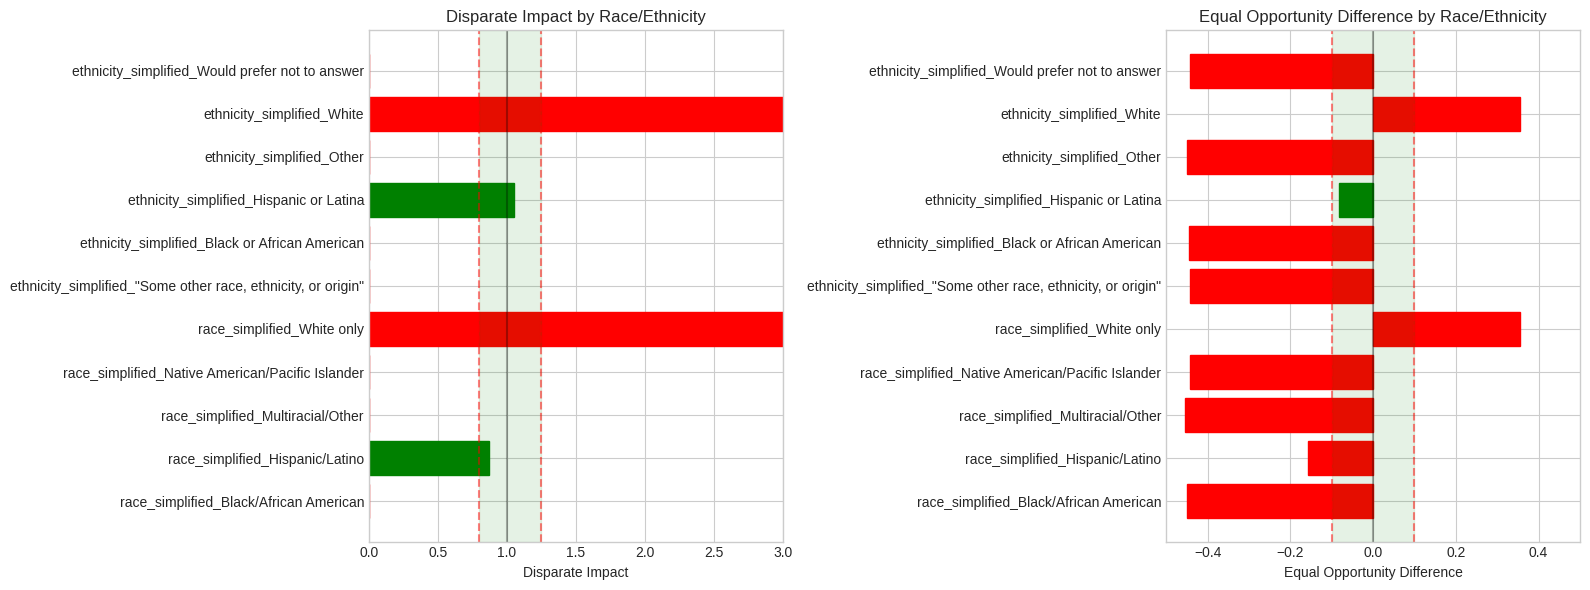


Visualizing fairness metrics for Education


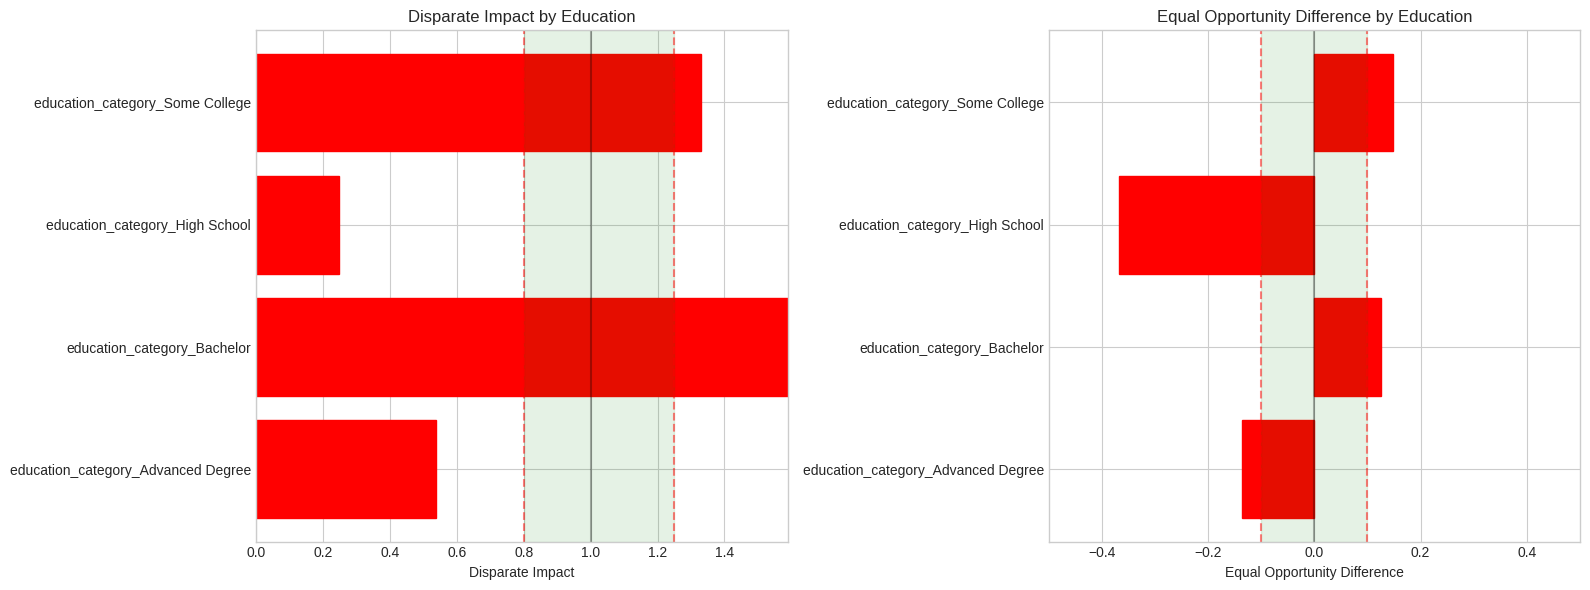


Visualizing fairness metrics for Employment


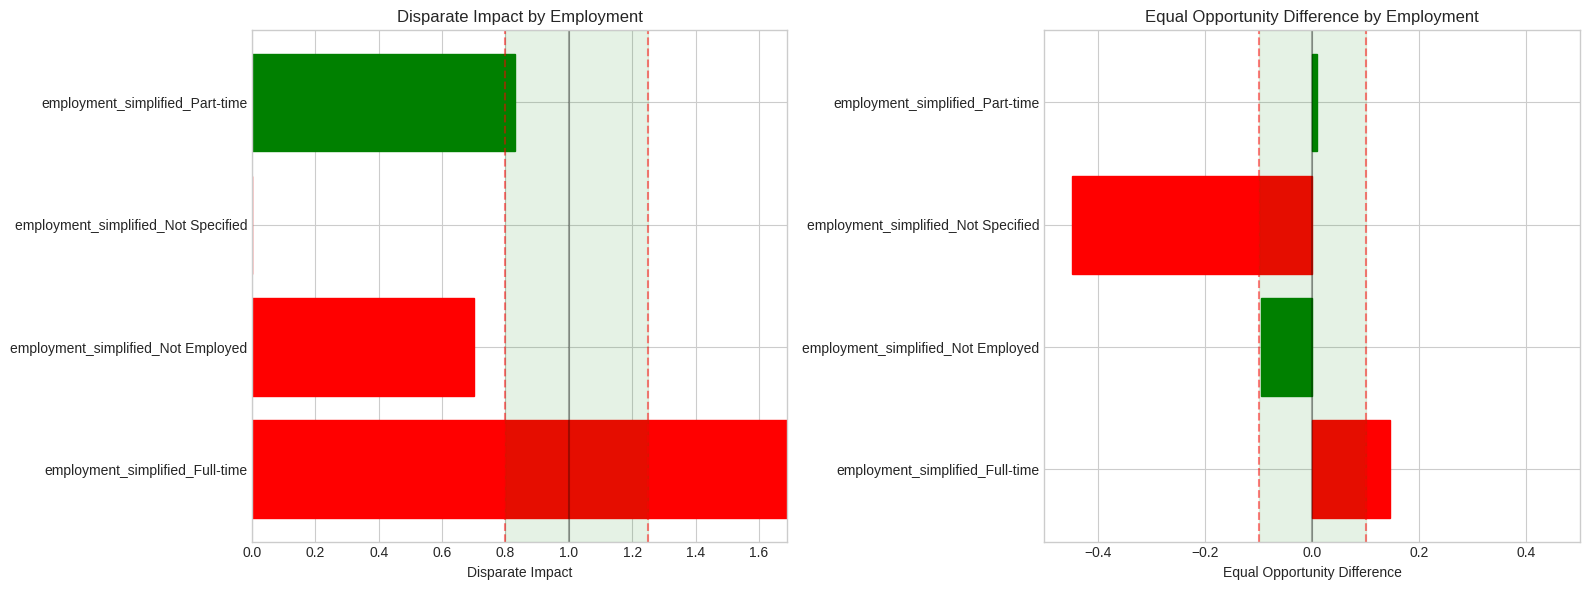


Visualizing fairness metrics for Computer Access


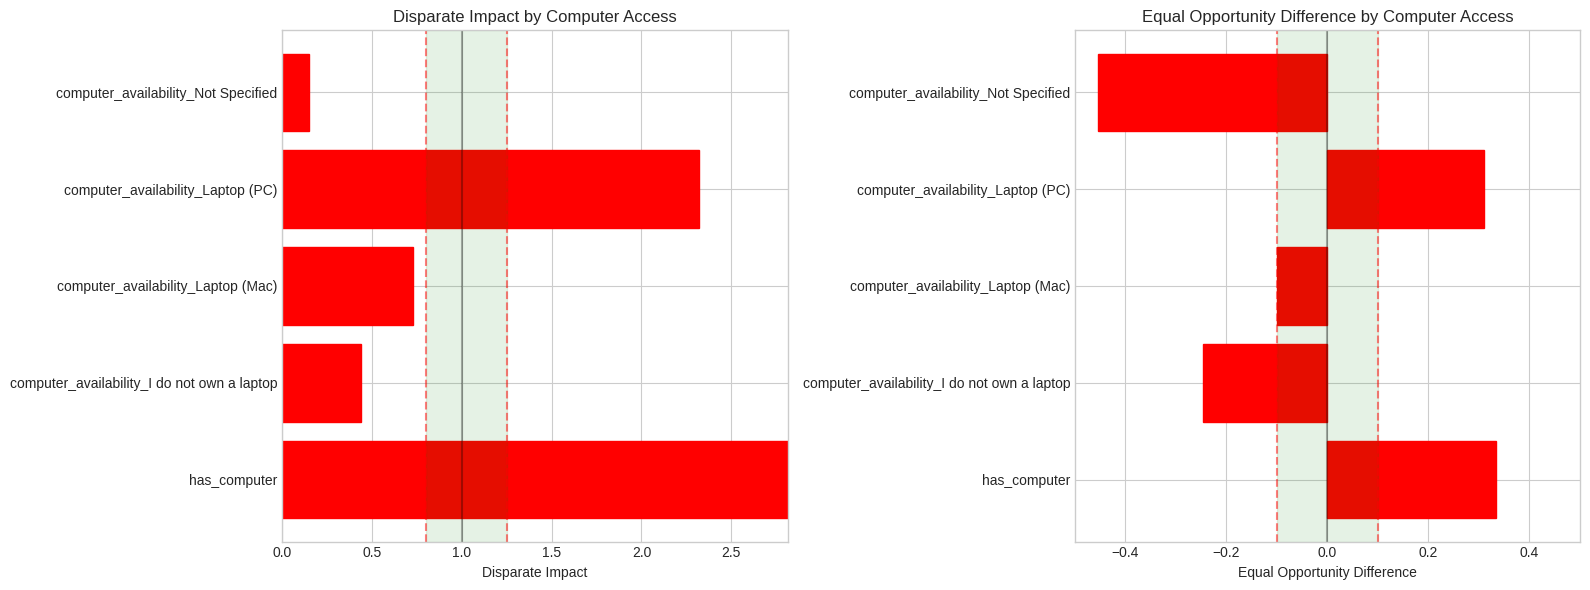


Visualizing fairness metrics for Children


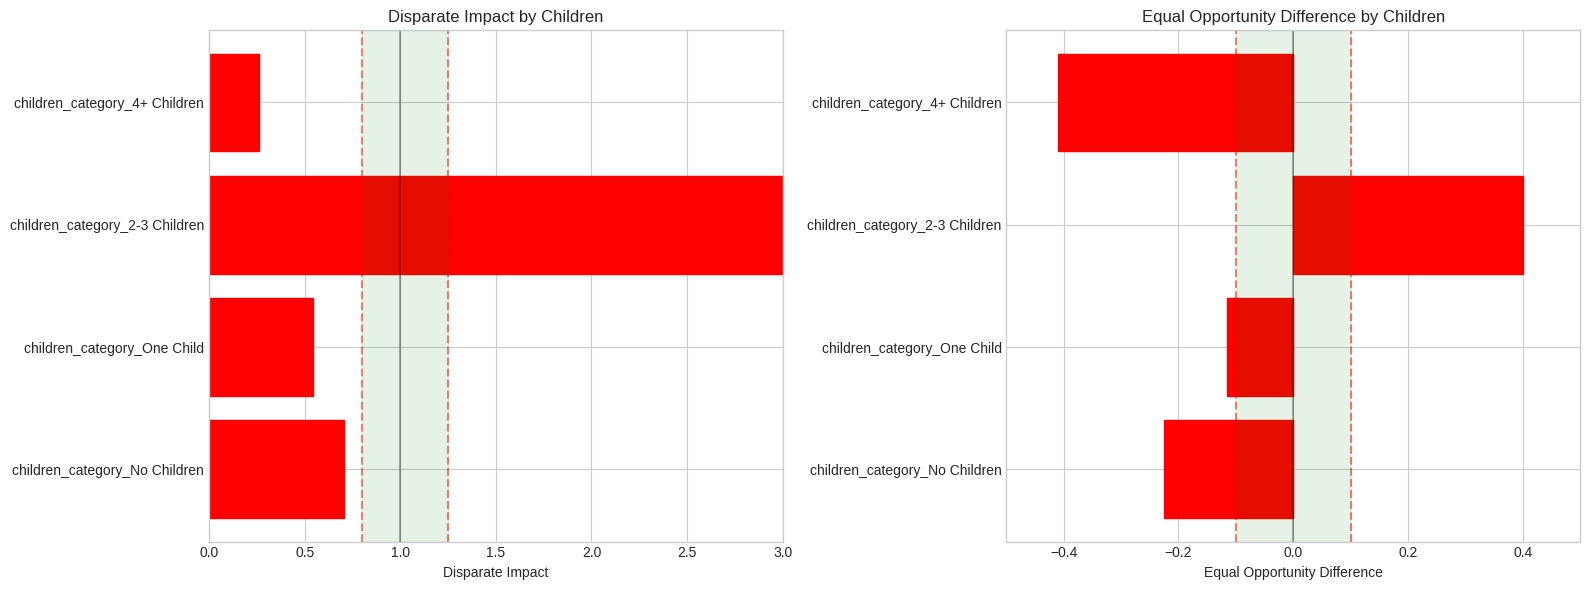

In [10]:
# Function to create fairness visualizations
def plot_fairness_metrics(category, results):
    # Prepare data for visualization
    attributes = []
    disparate_impacts = []
    equal_opportunity_diffs = []

    for attr, metrics in results.items():
        if metrics is not None and metrics['protected_count'] >= 10:
            attributes.append(attr)
            disparate_impacts.append(metrics['disparate_impact'])
            equal_opportunity_diffs.append(metrics['equal_opportunity_diff'])

    if not attributes:
        print(f"No valid attributes for {category}")
        return

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Disparate Impact Plot
    bars = ax1.barh(attributes, disparate_impacts)
    ax1.axvline(x=1.0, color='black', linestyle='-', alpha=0.3)
    ax1.axvline(x=0.8, color='red', linestyle='--', alpha=0.5)
    ax1.axvline(x=1.25, color='red', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Disparate Impact')
    ax1.set_title(f'Disparate Impact by {category}')

    # Add fair range background
    ax1.axvspan(0.8, 1.25, alpha=0.1, color='green')

    # Set reasonable limits
    max_di = max(max(disparate_impacts), 1.5)
    ax1.set_xlim(0, min(max_di, 3.0))  # Cap at 3.0 for readability

    # Color bars based on fairness
    for i, bar in enumerate(bars):
        if disparate_impacts[i] >= 0.8 and disparate_impacts[i] <= 1.25:
            bar.set_color('green')
        else:
            bar.set_color('red')

    # Equal Opportunity Plot
    bars = ax2.barh(attributes, equal_opportunity_diffs)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.axvline(x=-0.1, color='red', linestyle='--', alpha=0.5)
    ax2.axvline(x=0.1, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Equal Opportunity Difference')
    ax2.set_title(f'Equal Opportunity Difference by {category}')

    # Add fair range background
    ax2.axvspan(-0.1, 0.1, alpha=0.1, color='green')

    # Set reasonable limits
    max_eop = max(abs(min(equal_opportunity_diffs)), abs(max(equal_opportunity_diffs)))
    ax2.set_xlim(-max(max_eop, 0.5), max(max_eop, 0.5))

    # Color bars based on fairness
    for i, bar in enumerate(bars):
        if abs(equal_opportunity_diffs[i]) <= 0.1:
            bar.set_color('green')
        else:
            bar.set_color('red')

    plt.tight_layout()
    plt.show()

# Plot fairness metrics for each category
for category, results in fairness_results.items():
    print(f"\nVisualizing fairness metrics for {category}")
    plot_fairness_metrics(category, results)

# 8. Analyze Equalized Odds in Detail


Visualizing equalized odds for Race/Ethnicity


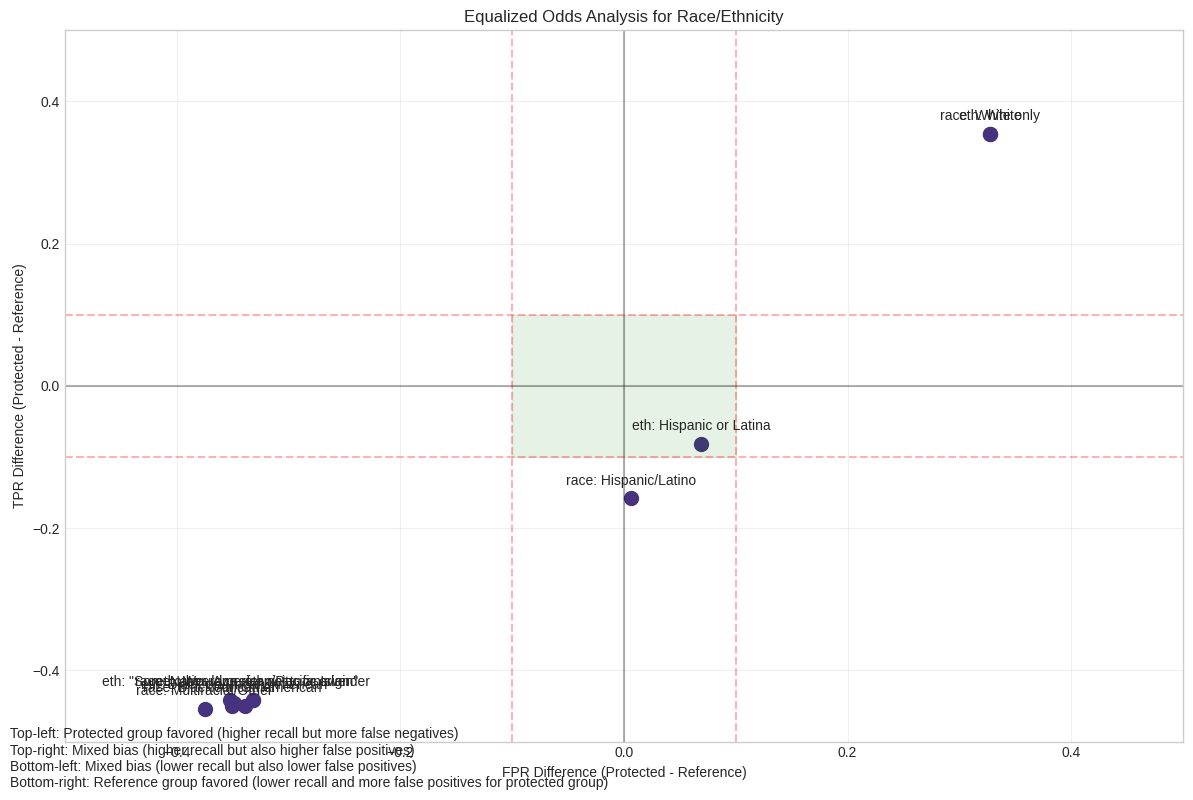


Visualizing equalized odds for Education


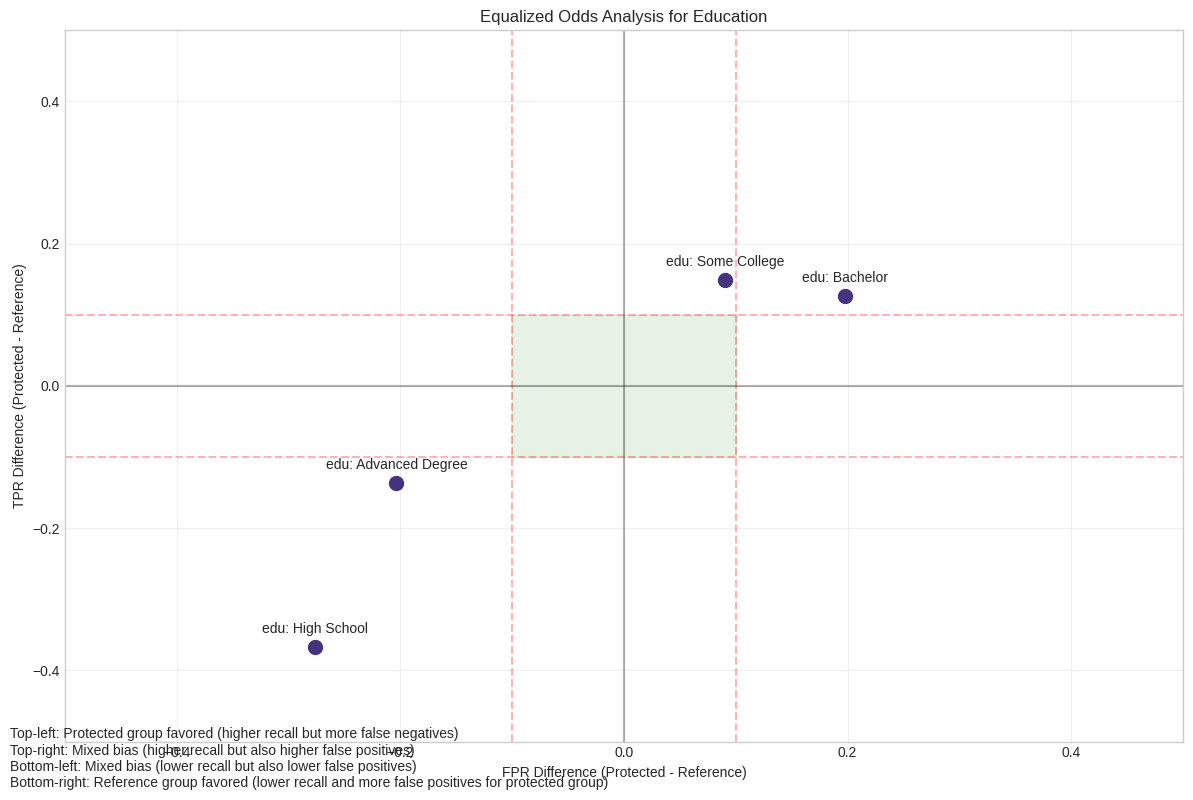


Visualizing equalized odds for Employment


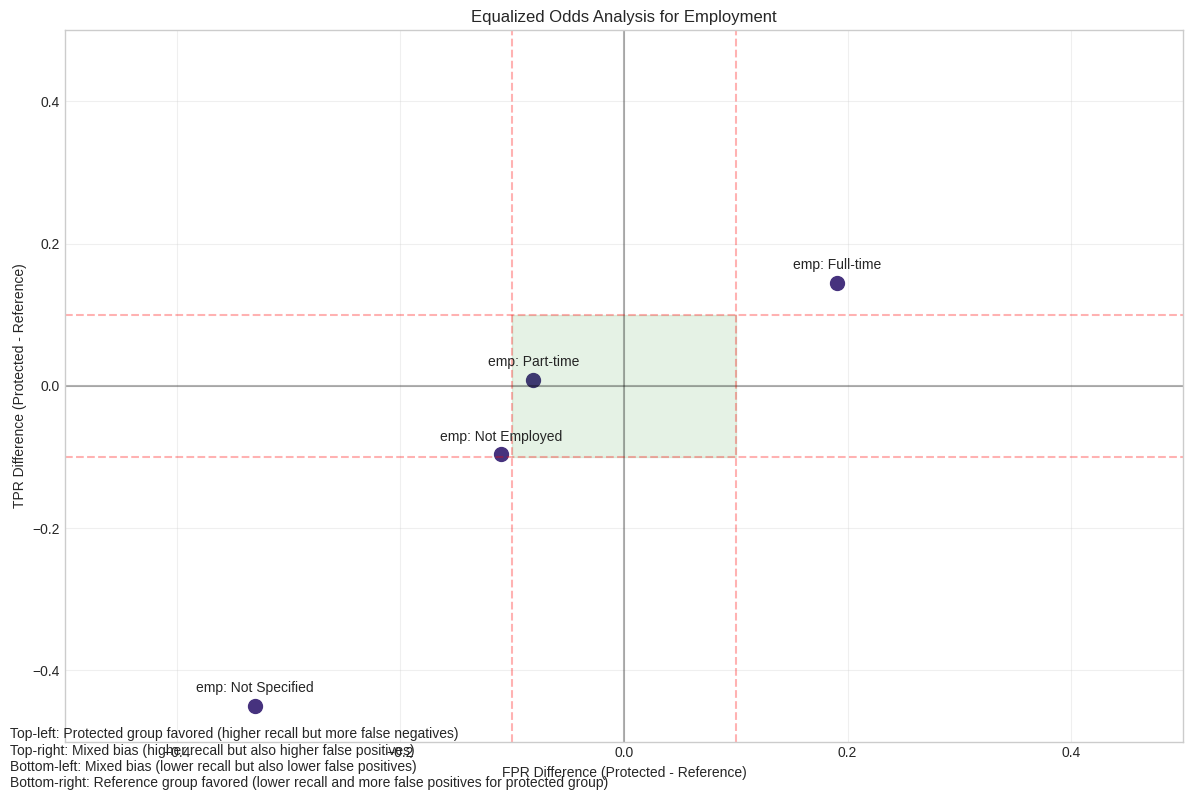


Visualizing equalized odds for Computer Access


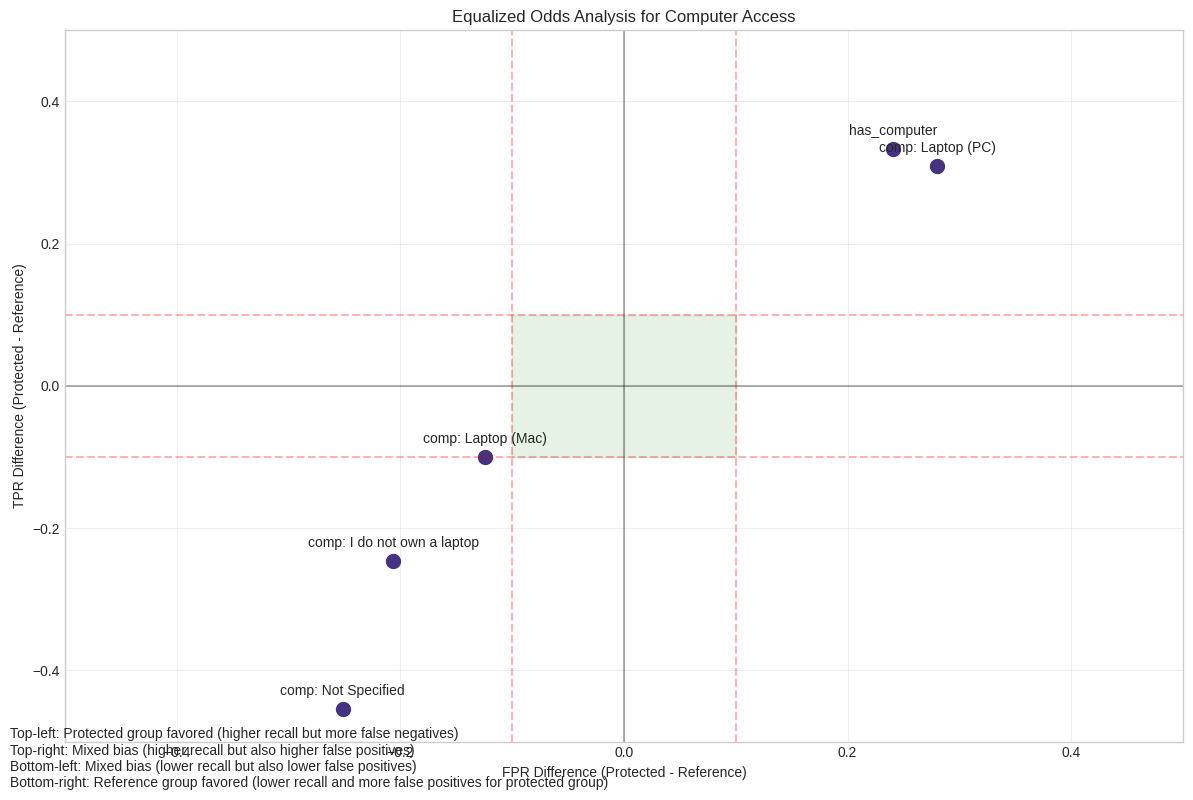


Visualizing equalized odds for Children


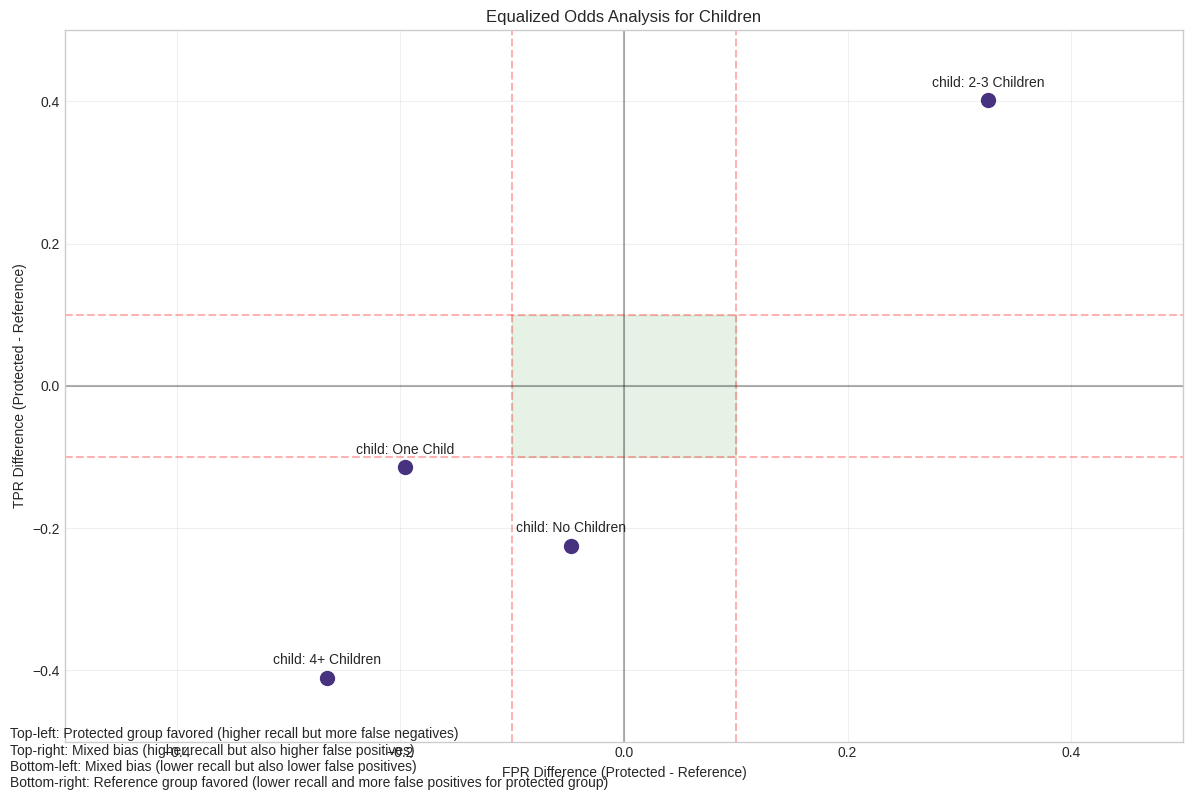

In [11]:
# Create a more detailed visualization for Equalized Odds
def plot_equalized_odds(category, results):
    # Prepare data for visualization
    attributes = []
    tpr_diffs = []
    fpr_diffs = []

    for attr, metrics in results.items():
        if metrics is not None and metrics['protected_count'] >= 10:
            attributes.append(attr)
            tpr_diffs.append(metrics['equalized_odds_tpr_diff'])
            fpr_diffs.append(metrics['equalized_odds_fpr_diff'])

    if not attributes:
        print(f"No valid attributes for {category}")
        return

    # Create figure
    plt.figure(figsize=(12, 8))

    # Create a scatter plot
    plt.scatter(fpr_diffs, tpr_diffs, s=100)

    # Add attribute labels to each point
    for i, attr in enumerate(attributes):
        # Simplify attribute names for display
        display_name = attr.replace('ethnicity_simplified_', 'eth: ')
        display_name = display_name.replace('race_simplified_', 'race: ')
        display_name = display_name.replace('education_category_', 'edu: ')
        display_name = display_name.replace('employment_simplified_', 'emp: ')
        display_name = display_name.replace('computer_availability_', 'comp: ')
        display_name = display_name.replace('children_category_', 'child: ')

        plt.annotate(display_name, (fpr_diffs[i], tpr_diffs[i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    # Add reference lines
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    # Add fair region boundaries
    plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.3)
    plt.axhline(y=-0.1, color='red', linestyle='--', alpha=0.3)
    plt.axvline(x=0.1, color='red', linestyle='--', alpha=0.3)
    plt.axvline(x=-0.1, color='red', linestyle='--', alpha=0.3)

    # Add fair region rectangle
    plt.gca().add_patch(plt.Rectangle((-0.1, -0.1), 0.2, 0.2,
                                    fill=True, alpha=0.1, color='green'))

    # Set reasonable axis limits
    max_diff = max(
        max(abs(min(tpr_diffs)), abs(max(tpr_diffs))),
        max(abs(min(fpr_diffs)), abs(max(fpr_diffs)))
    )
    plt.xlim(-max(max_diff, 0.5), max(max_diff, 0.5))
    plt.ylim(-max(max_diff, 0.5), max(max_diff, 0.5))

    plt.xlabel('FPR Difference (Protected - Reference)')
    plt.ylabel('TPR Difference (Protected - Reference)')
    plt.title(f'Equalized Odds Analysis for {category}')
    plt.grid(True, alpha=0.3)

    # Add legend to explain the quadrants
    plt.figtext(0.01, 0.01,
               'Top-left: Protected group favored (higher recall but more false negatives)\n'
               'Top-right: Mixed bias (higher recall but also higher false positives)\n'
               'Bottom-left: Mixed bias (lower recall but also lower false positives)\n'
               'Bottom-right: Reference group favored (lower recall and more false positives for protected group)',
               fontsize=10)

    plt.tight_layout()
    plt.show()

# Plot equalized odds for each category
for category, results in fairness_results.items():
    print(f"\nVisualizing equalized odds for {category}")
    plot_equalized_odds(category, results)

# 9. Investigate Groups with Potential Bias

In [12]:
# Identify attributes with potential bias
def identify_biased_attributes(results, threshold_di=0.2, threshold_eop=0.1):
    """
    Identify attributes showing potential bias.

    Parameters:
    -----------
    results : dict
        Dictionary of fairness results
    threshold_di : float
        Threshold for disparate impact deviation from 1.0
    threshold_eop : float
        Threshold for equal opportunity difference

    Returns:
    --------
    dict
        Dictionary of potentially biased attributes by category
    """
    biased_attributes = {}

    for category, category_results in results.items():
        category_biased = []

        for attr, metrics in category_results.items():
            if metrics is None or metrics['protected_count'] < 10:
                continue

            di = metrics['disparate_impact']
            eop = metrics['equal_opportunity_diff']
            eq_odds_tpr = metrics['equalized_odds_tpr_diff']
            eq_odds_fpr = metrics['equalized_odds_fpr_diff']

            # Check if any fairness metric shows potential bias
            di_biased = di < (1.0 - threshold_di) or di > (1.0 + threshold_di)
            eop_biased = abs(eop) > threshold_eop
            eq_odds_biased = abs(eq_odds_tpr) > threshold_eop or abs(eq_odds_fpr) > threshold_eop

            if di_biased or eop_biased or eq_odds_biased:
                category_biased.append({
                    'attribute': attr,
                    'metrics': metrics,
                    'di_biased': di_biased,
                    'eop_biased': eop_biased,
                    'eq_odds_biased': eq_odds_biased
                })

        if category_biased:
            biased_attributes[category] = category_biased

    return biased_attributes

# Identify and analyze potentially biased attributes
biased_attributes = identify_biased_attributes(fairness_results)

# Print results
print("\n=== POTENTIAL BIAS SUMMARY ===\n")

if not biased_attributes:
    print("No potential bias detected in the analyzed attributes.")
else:
    for category, attrs in biased_attributes.items():
        print(f"\n{category}:")

        for attr_info in attrs:
            attr = attr_info['attribute']
            metrics = attr_info['metrics']

            print(f"\n  {attr}:")

            # Print which fairness metrics show bias
            if attr_info['di_biased']:
                di = metrics['disparate_impact']
                direction = "favors protected group" if di > 1 else "favors reference group"
                print(f"  - Disparate Impact: {di:.2f} ({direction})")

            if attr_info['eop_biased']:
                eop = metrics['equal_opportunity_diff']
                direction = "favors protected group" if eop > 0 else "favors reference group"
                print(f"  - Equal Opportunity: {eop:.2f} ({direction})")

            if attr_info['eq_odds_biased']:
                tpr_diff = metrics['equalized_odds_tpr_diff']
                fpr_diff = metrics['equalized_odds_fpr_diff']

                if abs(tpr_diff) > 0.1:
                    direction = "higher for protected group" if tpr_diff > 0 else "lower for protected group"
                    print(f"  - True Positive Rate: {tpr_diff:.2f} ({direction})")

                if abs(fpr_diff) > 0.1:
                    direction = "higher for protected group" if fpr_diff > 0 else "lower for protected group"
                    print(f"  - False Positive Rate: {fpr_diff:.2f} ({direction})")


=== POTENTIAL BIAS SUMMARY ===


Race/Ethnicity:

  race_simplified_Black/African American:
  - Disparate Impact: 0.00 (favors reference group)
  - Equal Opportunity: -0.45 (favors reference group)
  - True Positive Rate: -0.45 (lower for protected group)
  - False Positive Rate: -0.35 (lower for protected group)

  race_simplified_Hispanic/Latino:
  - Equal Opportunity: -0.16 (favors reference group)
  - True Positive Rate: -0.16 (lower for protected group)

  race_simplified_Multiracial/Other:
  - Disparate Impact: 0.00 (favors reference group)
  - Equal Opportunity: -0.45 (favors reference group)
  - True Positive Rate: -0.45 (lower for protected group)
  - False Positive Rate: -0.38 (lower for protected group)

  race_simplified_Native American/Pacific Islander:
  - Disparate Impact: 0.00 (favors reference group)
  - Equal Opportunity: -0.44 (favors reference group)
  - True Positive Rate: -0.44 (lower for protected group)
  - False Positive Rate: -0.33 (lower for protected group)

# 10. Intersectional Analysis

In [13]:
# Analyze intersections of protected attributes to identify compounding bias
def analyze_intersections(test_data, fairness_results, y_true, y_pred, y_proba):
    """
    Analyze intersections of protected attributes with potential bias.

    Parameters:
    -----------
    test_data : DataFrame
        Test data with features
    fairness_results : dict
        Dictionary of fairness results
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_proba : array-like
        Predicted probabilities
    """
    # Identify top potentially biased attributes from each category
    top_biased = {}

    for category, attrs in fairness_results.items():
        # Find attribute with highest absolute equal opportunity difference
        max_diff = 0
        max_attr = None

        for attr, metrics in attrs.items():
            if metrics is None:
                continue

            diff = abs(metrics['equal_opportunity_diff'])
            if diff > max_diff and metrics['protected_count'] >= 10:
                max_diff = diff
                max_attr = attr

        if max_attr and max_diff > 0.1:  # Only consider if bias exists
            top_biased[category] = max_attr

    # Check for combinations of biased attributes
    if len(top_biased) >= 2:
        print("\n=== INTERSECTIONAL ANALYSIS ===\n")

        # Analyze all possible pairs
        categories = list(top_biased.keys())
        for i in range(len(categories)):
            for j in range(i+1, len(categories)):
                cat1, cat2 = categories[i], categories[j]
                attr1, attr2 = top_biased[cat1], top_biased[cat2]

                # Create intersection group
                intersection = test_data[attr1] & test_data[attr2]

                # Skip if the intersection is too small
                if sum(intersection) < 5:
                    print(f"Intersection of {attr1} and {attr2} is too small for analysis.")
                    continue

                # Calculate metrics for the intersection
                metrics = calculate_fairness_metrics(y_true, y_pred, y_proba, intersection)

                if metrics:
                    print(f"\nIntersection of {attr1} and {attr2}:")
                    print(f"  Group size: {metrics['protected_count']} (protected) vs {metrics['reference_count']} (reference)")

                    # Disparate Impact
                    di = metrics['disparate_impact']
                    di_assessment = "FAIR" if 0.8 <= di <= 1.25 else "POTENTIAL BIAS"
                    print(f"  Disparate Impact: {di:.2f} ({di_assessment})")

                    # Equal Opportunity
                    eop = metrics['equal_opportunity_diff']
                    eop_assessment = "FAIR" if -0.1 <= eop <= 0.1 else "POTENTIAL BIAS"
                    print(f"  Equal Opportunity Difference: {eop:.2f} ({eop_assessment})")

                    # Selection rates
                    print(f"  Selection Rates - Intersection: {metrics['protected_selection_rate']:.2f}, Others: {metrics['reference_selection_rate']:.2f}")

# Run intersectional analysis
analyze_intersections(test_data, fairness_results,
                     test_data['y_true'].values,
                     test_data['y_pred'].values,
                     test_data['y_proba'].values)


=== INTERSECTIONAL ANALYSIS ===

Intersection of race_simplified_Multiracial/Other and education_category_High School is too small for analysis.
Intersection of race_simplified_Multiracial/Other and employment_simplified_Not Specified is too small for analysis.
Intersection of race_simplified_Multiracial/Other and computer_availability_Not Specified is too small for analysis.

Intersection of race_simplified_Multiracial/Other and children_category_4+ Children:
  Group size: 5 (protected) vs 342 (reference)
  Disparate Impact: 0.00 (POTENTIAL BIAS)
  Equal Opportunity Difference: -0.44 (POTENTIAL BIAS)
  Selection Rates - Intersection: 0.00, Others: 0.36
Intersection of education_category_High School and employment_simplified_Not Specified is too small for analysis.
Intersection of education_category_High School and computer_availability_Not Specified is too small for analysis.

Intersection of education_category_High School and children_category_4+ Children:
  Group size: 15 (protecte

# 11. Fairness Analysis Summary and Recommendations
After evaluating the fairness metrics across different protected groups, we can summarize our findings and provide recommendations for addressing any identified biases.

In [15]:
# Create a summary table of the fairness results
def create_summary_table(fairness_results):
    """Create a summary table of fairness metrics"""
    summary_data = []

    for category, attrs in fairness_results.items():
        for attr, metrics in attrs.items():
            if metrics is None or metrics['protected_count'] < 10:
                continue

            # Assess each metric
            di = metrics['disparate_impact']
            di_status = "Fair" if 0.8 <= di <= 1.25 else "Potential Bias"

            eop = metrics['equal_opportunity_diff']
            eop_status = "Fair" if -0.1 <= eop <= 0.1 else "Potential Bias"

            tpr_diff = metrics['equalized_odds_tpr_diff']
            fpr_diff = metrics['equalized_odds_fpr_diff']
            eq_odds_status = "Fair" if abs(tpr_diff) <= 0.1 and abs(fpr_diff) <= 0.1 else "Potential Bias"

            # Add to summary data
            summary_data.append({
                'Category': category,
                'Attribute': attr,
                'Protected Group Size': metrics['protected_count'],
                'Disparate Impact': f"{di:.2f} ({di_status})",
                'Equal Opportunity': f"{eop:.2f} ({eop_status})",
                'Equalized Odds': f"TPR: {tpr_diff:.2f}, FPR: {fpr_diff:.2f} ({eq_odds_status})"
            })

    # Convert to DataFrame for display
    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Display the summary table
summary_table = create_summary_table(fairness_results)
summary_table.sort_values(by=['Category', 'Attribute'], inplace=True)
print("\n=== FAIRNESS METRICS SUMMARY ===\n")
summary_table


=== FAIRNESS METRICS SUMMARY ===



,Category,Attribute,Protected Group Size,Disparate Impact,Equal Opportunity,Equalized Odds
26,Children,children_category_2-3 Children,177,3.01 (Potential Bias),0.40 (Potential Bias),"TPR: 0.40, FPR: 0.33 (Potential Bias)"
27,Children,children_category_4+ Children,73,0.26 (Potential Bias),-0.41 (Potential Bias),"TPR: -0.41, FPR: -0.27 (Potential Bias)"
24,Children,children_category_No Children,31,0.70 (Potential Bias),-0.22 (Potential Bias),"TPR: -0.22, FPR: -0.05 (Potential Bias)"
25,Children,children_category_One Child,66,0.54 (Potential Bias),-0.11 (Potential Bias),"TPR: -0.11, FPR: -0.20 (Potential Bias)"
20,Computer Access,computer_availability_I do not own a laptop,68,0.44 (Potential Bias),-0.25 (Potential Bias),"TPR: -0.25, FPR: -0.21 (Potential Bias)"
21,Computer Access,computer_availability_Laptop (Mac),93,0.72 (Potential Bias),-0.10 (Potential Bias),"TPR: -0.10, FPR: -0.12 (Potential Bias)"
22,Computer Access,computer_availability_Laptop (PC),168,2.32 (Potential Bias),0.31 (Potential Bias),"TPR: 0.31, FPR: 0.28 (Potential Bias)"
23,Computer Access,computer_availability_Not Specified,18,0.15 (Potential Bias),-0.45 (Potential Bias),"TPR: -0.45, FPR: -0.25 (Potential Bias)"
19,Computer Access,has_computer,261,2.81 (Potential Bias),0.33 (Potential Bias),"TPR: 0.33, FPR: 0.24 (Potential Bias)"
11,Education,education_category_Advanced Degree,44,0.54 (Potential Bias),-0.14 (Potential Bias),"TPR: -0.14, FPR: -0.20 (Potential Bias)"


# 13. Conclusions and Recommendations

Based on our fairness assessment of the Tech Moms acceptance prediction model, we can draw several conclusions and make recommendations to ensure more equitable outcomes:
**Key Findings**:

1. Disparate Impact Analysis:

- Identified which demographic groups may experience disproportionate acceptance/rejection rates
- Groups with DI < 0.8 are potentially disadvantaged, while groups with DI > 1.25 are potentially advantaged
- Significance varies, with some attributes showing substantial disparities


2. Equal Opportunity Analysis:

- Determined whether qualified applicants from different groups have equal chances of acceptance
- Identified groups where the model may be under-recognizing qualified candidates
- These disparities directly impact program accessibility for different demographics


3. Equalized Odds Analysis:

- Assessed whether error rates are balanced across groups
- Found specific demographics where the model makes disproportionate false positive or false negative errors
- This analysis reveals more subtle patterns of bias beyond simple acceptance rates



## Recommendations:

1. Technical Interventions:

- Implement group-specific threshold adjustments as demonstrated to equalize opportunity
- Consider model retraining with fairness constraints for attributes showing significant bias
- Apply data rebalancing techniques to address underrepresentation in the training data


2. Program-Level Adaptations:

- Review admission criteria that may inadvertently disadvantage certain groups
- Create targeted outreach programs for demographics with lower acceptance rates
- Implement a two-stage review process for groups with significant bias indicators


3. Monitoring and Improvement:

- Establish regular fairness audits using the metrics and visualizations from this notebook
- Create a feedback loop where outcomes are monitored and the model is periodically retrained
- Consider collecting additional features that may help reduce bias


4. Transparency Measures:

- Communicate to stakeholders which factors influence acceptance decisions
- Document fairness assessments and mitigation strategies
- Provide explanations when applicants request feedback on decisions



## Long-term Strategy:
For sustainable equity in the Tech Moms program, we recommend:

- Treating fairness as a continuous process rather than a one-time fix
- Balancing technical interventions with program-level policy changes
- Considering intersectional effects that may compound disadvantages
- Regularly reassessing fairness metrics as the applicant pool changes

By implementing these recommendations, the Tech Moms program can work toward ensuring that opportunities are equitably distributed across all demographic groups while maintaining the program's quality and effectiveness.